In [1]:
import pandas as pd
import numpy as np
import random as random

# plotly standard imports
import plotly.graph_objs as go
import plotly.plotly as py



In [2]:
# Cufflinks wrapper on plotly
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot
cufflinks.go_offline()

# Set global theme
cufflinks.set_config_file(world_readable=True, theme='pearl')
import plotly.figure_factory as ff


# Data input

In [3]:
input_df=pd.read_csv("train.csv", sep=",")
X=input_df.drop("revenue", axis=1) # drop labels for training set
y=input_df["revenue"]

In [4]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
type(y_train)

pandas.core.series.Series

In [7]:
X_train.reset_index(inplace=True);
X_test.reset_index(inplace=True);

In [8]:
df=pd.concat([X_train, y_train], axis=1, sort=False)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2731 entries, 0 to 2998
Data columns (total 24 columns):
index                    2100 non-null float64
id                       2100 non-null float64
belongs_to_collection    425 non-null object
budget                   2100 non-null float64
genres                   2095 non-null object
homepage                 673 non-null object
imdb_id                  2100 non-null object
original_language        2100 non-null object
original_title           2100 non-null object
overview                 2092 non-null object
popularity               2100 non-null float64
poster_path              2099 non-null object
production_companies     1978 non-null object
production_countries     2059 non-null object
release_date             2100 non-null object
runtime                  2098 non-null float64
spoken_languages         2085 non-null object
status                   2100 non-null object
tagline                  1659 non-null object
title           

# Removing Nulls and Data exploration

In [10]:
X_train.isna().sum()

index                       0
id                          0
belongs_to_collection    1675
budget                      0
genres                      5
homepage                 1427
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      122
production_countries       41
release_date                0
runtime                     2
spoken_languages           15
status                      0
tagline                   441
title                       0
Keywords                  194
cast                        9
crew                       12
dtype: int64

In [11]:
from sklearn.base import TransformerMixin

In [12]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)


In [13]:
X_train_t=DataFrameImputer().fit_transform(X_train)

In [14]:
df_t=DataFrameImputer().fit_transform(df)

In [15]:
X_train_t.isna().sum()

index                    0
id                       0
belongs_to_collection    0
budget                   0
genres                   0
homepage                 0
imdb_id                  0
original_language        0
original_title           0
overview                 0
popularity               0
poster_path              0
production_companies     0
production_countries     0
release_date             0
runtime                  0
spoken_languages         0
status                   0
tagline                  0
title                    0
Keywords                 0
cast                     0
crew                     0
dtype: int64

In [16]:
#Comparing correlatons between Consumption_per_NIA/log_NIA/Property Type 


figure = ff.create_scatterplotmatrix(
    df[['budget', 'popularity',"runtime","revenue"]],
    height=1000,
    width=1000,
    diag='histogram',
    title="Data Exploration")
iplot(figure)

In [17]:
corrs = df[["revenue","popularity","runtime","budget"]].corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)

iplot(figure)

# Feature engineering

In [18]:
import ast


def cat_list(line):
    c_list=[]
    line_eval=ast.literal_eval(line)
    for d in line_eval:
        c_list.append(d["name"])
    return(c_list)

In [19]:
def get_left(string):
    try:
        if len(string)==8:
            return(int(string[:2]))
        else:
            return(int(string[:1]))
    except: return 0

In [20]:

def get_year(string):
    try:
        if int(string[-2:])< 20:
            return int(string[-2:])+2000
        else:
            return int(string[-2:])+1900
    except:
        return 0

In [21]:
X_train_t.head()

,index,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,...,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew
0,611,612,"[{'id': 645, 'name': 'James Bond Collection', ...",8575000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://www.transformersmovie.com/,tt4016934,ko,아가씨,"1930s Korea, in the period of Japanese occupat...",...,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",6/1/16,145.0,"[{'iso_639_1': 'ja', 'name': '日本語'}, {'iso_639...",Released,Never did they expect to get into a controvers...,The Handmaiden,"[{'id': 293, 'name': 'female nudity'}, {'id': ...","[{'cast_id': 3, 'character': 'Lady Hideko', 'c...","[{'credit_id': '54056d0b0e0a2658f100c167', 'de..."
1,530,531,"[{'id': 366444, 'name': 'Demetrius Filmreihe',...",4100000,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt0046247,en,The Robe,Marcellus is a tribune in the time of Christ. ...,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",9/16/53,135.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The first motion picture in CinemaScope--the m...,The Robe,"[{'id': 3571, 'name': 'crucifixion'}, {'id': 5...","[{'cast_id': 1, 'character': 'Marcellus Gallio...","[{'credit_id': '52fe4603c3a368484e07be21', 'de..."
2,2787,2788,"[{'id': 645, 'name': 'James Bond Collection', ...",80000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",http://www.transformersmovie.com/,tt1037705,en,The Book of Eli,"A post-apocalyptic tale, in which a lone man f...",...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1/14/10,118.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Some will kill to have it. He will kill to pro...,The Book of Eli,"[{'id': 3096, 'name': 'book'}, {'id': 4458, 'n...","[{'cast_id': 1, 'character': 'Eli', 'credit_id...","[{'credit_id': '52fe43e9c3a368484e0058ad', 'de..."
3,49,50,"[{'id': 115570, 'name': 'Star Trek: The Next G...",38000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://www.transformersmovie.com/,tt0111280,en,Star Trek: Generations,Captain Jean-Luc Picard and the crew of the En...,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",11/17/94,118.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Boldly go.,Star Trek: Generations,"[{'id': 10988, 'name': 'based on tv series'}, ...","[{'cast_id': 5, 'character': 'Captain Jean-Luc...","[{'credit_id': '52fe4225c3a36847f80076c3', 'de..."
4,1883,1884,"[{'id': 454520, 'name': 'Captain Harlock Colle...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",http://www.transformersmovie.com/,tt2668134,ja,キャプテンハーロック,Space Pirate Captain Harlock and his fearless ...,...,"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",9/7/13,115.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,Revenge is Sweet.,Space Pirate Captain Harlock,"[{'id': 10183, 'name': 'independent film'}]","[{'cast_id': 1, 'character': 'Captain Harlock ...","[{'credit_id': '52fe4cac9251416c910fc711', 'de..."


In [22]:
from sklearn.base import BaseEstimator, TransformerMixin

In [23]:
df.columns

Index(['index', 'id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')

In [24]:

class DateAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        """

        init
        """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
       
        year=X['release_date'].apply(lambda x: get_year(x))
        df_year=pd.DataFrame(year.values,columns=["year"])
        month=X['release_date'].apply(lambda x:get_left(x))
        df_month=pd.DataFrame(month.values,columns=["month"])
       
        processed_X=pd.concat([X, df_year, df_month], axis=1, sort=False)
      
        return processed_X

In [25]:
attr_adder=DateAttributesAdder()
X_train_t2=attr_adder.fit_transform(X_train_t)

In [26]:
X_train_t2.columns

Index(['index', 'id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'year',
       'month'],
      dtype='object')

# Unpacking categories and spoken languages

In [27]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)

class CatAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        genres_list=X["genres"].apply(lambda x: cat_list(x))
        genres_label_data=mlb.fit_transform(genres_list)
        genres_labelClasses = mlb.classes_
        genresLabels=pd.DataFrame(genres_label_data, columns=genres_labelClasses)
        
        language_list=X['spoken_languages'].apply(lambda x: cat_list(x))
        language_label_data=mlb.fit_transform(language_list)
        language_labelClasses =  "spoken_lan_" + mlb.classes_
        languageLabels=pd.DataFrame(language_label_data, columns=language_labelClasses)
        languageLabels=languageLabels[[ 'spoken_lan_Deutsch', 'spoken_lan_English', 'spoken_lan_Español', 'spoken_lan_Français', 'spoken_lan_Italiano', 'spoken_lan_Pусский']]
        
        
        prod_country=X['production_countries'].apply(lambda x: cat_list(x))
        prod_country_label_data=mlb.fit_transform(prod_country)
        prod_country_labelClasses =  "prod_country_" + mlb.classes_
        prod_countryLabels=pd.DataFrame(prod_country_label_data, columns=prod_country_labelClasses)
        prod_countryLabels=prod_countryLabels[prod_countryLabels.columns[prod_countryLabels.sum()>len(X)/20]]
        
        
        prod_company=X['production_companies'].apply(lambda x: cat_list(x))
        prod_company_label_data=mlb.fit_transform(prod_company)
        prod_company_labelClasses = mlb.classes_
        prod_companyLabels=pd.DataFrame(prod_company_label_data, columns=prod_company_labelClasses)
        prod_companyLabels=prod_companyLabels[prod_companyLabels.columns[prod_companyLabels.sum()>len(X)/50]]
        
        org_lan_cat_1hot = cat_encoder.fit_transform(X[["original_language"]])
        df_org_lan=pd.DataFrame(org_lan_cat_1hot, columns=cat_encoder.categories_[0])
        df_org_lan=df_org_lan[df_org_lan.columns[df_org_lan.sum()>len(X)/100]]
        
        processed_X=pd.concat([X, genresLabels,languageLabels, prod_countryLabels, df_org_lan, prod_companyLabels], axis=1, sort=False)
        
         
        processed_X=processed_X[['budget',
                                   'popularity',
                                      'runtime',
                                       'Action',
                                    'Adventure',
                                    'Animation',
                                       'Comedy',
                                        'Crime',
                                  'Documentary',
                                        'Drama',
                                       'Family',
                                      'Fantasy',
                                      'Foreign',
                                      'History',
                                       'Horror',
                                        'Music',
                                      'Mystery',
                                      'Romance',
                              'Science Fiction',
                                     'Thriller',
                                          'War',
                                      'Western',
                           'spoken_lan_Deutsch',
                           'spoken_lan_English',
                           'spoken_lan_Español',
                          'spoken_lan_Français',
                          'spoken_lan_Italiano',
                           'spoken_lan_Pусский',
                          'prod_country_France',
                         'prod_country_Germany',
                  'prod_country_United Kingdom',
        'prod_country_United States of America',
                                        'en',
                                        'es',
                                        'fr',
                                        'hi',
                            'Columbia Pictures',
                    'Metro-Goldwyn-Mayer (MGM)',
                              'New Line Cinema',
                           'Paramount Pictures',
                          'Touchstone Pictures',
       'Twentieth Century Fox Film Corporation',
                           'Universal Pictures',
                                 'Warner Bros.', 
            "year", 
            "month"]]
        
        X["decade"]=(X["year"]-X["year"]%10)
        

        decade_cat_1hot = cat_encoder.fit_transform(X[["decade"]])
        df_year=pd.DataFrame(decade_cat_1hot, columns=cat_encoder.categories_[0])
        
        month_cat_1hot = cat_encoder.fit_transform(X[["month"]])
        df_month=pd.DataFrame(month_cat_1hot, columns=list(cat_encoder.categories_[0]))
        df_month.rename(columns={1: "Jan", 2: "Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Nov", 11:"Oct", 12:"Dec"}, inplace = True)


        
        processed_X=pd.concat([processed_X, df_year, df_month], axis=1, sort=False)
        
        processed_X=processed_X.drop(columns=["year","month"])
        return(processed_X)
        
        
     

In [28]:

attr_adder=CatAttributesAdder()
X_train_t3=attr_adder.fit_transform(X_train_t2)

In [29]:
X_train_t3.columns

Index([                                'budget',
                                   'popularity',
                                      'runtime',
                                       'Action',
                                    'Adventure',
                                    'Animation',
                                       'Comedy',
                                        'Crime',
                                  'Documentary',
                                        'Drama',
                                       'Family',
                                      'Fantasy',
                                      'Foreign',
                                      'History',
                                       'Horror',
                                        'Music',
                                      'Mystery',
                                      'Romance',
                              'Science Fiction',
                                     'Thriller',
                    

In [30]:
X=X_train_t2
X["decade"]=(X["year"]-X["year"]%10)
        

year_cat_1hot = cat_encoder.fit_transform(X[["decade"]])
df_year=pd.DataFrame(year_cat_1hot, columns=cat_encoder.categories_)

In [31]:
df_year.columns

MultiIndex(levels=[[1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]],
           codes=[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [32]:
month_cat_1hot = cat_encoder.fit_transform(X[["month"]])
df_month=pd.DataFrame(month_cat_1hot, columns=list(cat_encoder.categories_[0]))
df_month.rename(columns={1: "Jan", 2: "Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Nov", 11:"Oct", 12:"Dec"}, inplace=True)

In [33]:
df_month.columns

Index(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Nov',
       'Oct', 'Dec'],
      dtype='object')

In [34]:
list(cat_encoder.categories_[0])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Preparation Pipeline

In [191]:
from sklearn.preprocessing import PolynomialFeatures
Poly_Feat=PolynomialFeatures(degree=3, include_bias=False)

class PolyAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        """

        init
        """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_num=X[["budget","runtime","popularity"]]
        X_poly=Poly_Feat.fit_transform(X_num)
        poly_columns=[]
        for col in Poly_Feat.get_feature_names():
            col=str(col).replace("x0","budget")
            col=str(col).replace("x1","runtime")
            col=str(col).replace("x2","popularity")
            poly_columns.append(col)

        
        df_poly=pd.DataFrame(X_poly, columns=poly_columns)
        df_poly.drop(["budget","runtime","popularity"], axis=1, inplace=True)
        processed_X=pd.concat([X, df_poly], axis=1, sort=False)
    
        return processed_X
  

In [120]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_atrribs=[["budget", "runtime","popularity"]]

polynomial_pipeline = Pipeline([
    ("imputer", DataFrameImputer()),
    ("date_adder", DateAttributesAdder()),
    ("cat_adder", CatAttributesAdder()),
    ("polynomial_adder", PolyAttributesAdder(),)
    ])

list

In [192]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preparation_pipeline = Pipeline([
    ("imputer", DataFrameImputer()),
    ("date_adder", DateAttributesAdder()),
    ("cat_adder", CatAttributesAdder()),
    ("polynomial_adder", PolyAttributesAdder(),)

    ])

In [193]:
X_train_prep=preparation_pipeline.fit_transform(X_train)

In [194]:
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 82 columns):
budget                                    2100 non-null int64
popularity                                2100 non-null float64
runtime                                   2100 non-null float64
Action                                    2100 non-null int32
Adventure                                 2100 non-null int32
Animation                                 2100 non-null int32
Comedy                                    2100 non-null int32
Crime                                     2100 non-null int32
Documentary                               2100 non-null int32
Drama                                     2100 non-null int32
Family                                    2100 non-null int32
Fantasy                                   2100 non-null int32
Foreign                                   2100 non-null int32
History                                   2100 non-null int32
Horror               

In [195]:
X_train_prep.head()

,budget,popularity,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,budget^3,budget^2 runtime,budget^2 popularity,budget runtime^2,budget runtime popularity,budget popularity^2,runtime^3,runtime^2 popularity,runtime popularity^2,popularity^3
0,8575000,16.727405,145.0,0,0,0,0,0,0,1,...,6.305251e+20,1.066194e+16,1.229977e+15,1.802894e+11,2.079844e+10,2.399337e+09,3048625.0,351693.690125,40571.881315,4680.429589
1,4100000,3.826281,135.0,0,0,0,0,0,0,1,...,6.892100e+19,2.269350e+15,6.431978e+13,7.472250e+10,2.117847e+09,6.002575e+07,2460375.0,69733.971225,1976.457549,56.018385
2,80000000,14.398530,118.0,1,0,0,0,0,0,0,...,5.120000e+23,7.552000e+17,9.215059e+16,1.113920e+12,1.359221e+11,1.658541e+10,1643032.0,200485.131720,24463.484607,2985.069636
3,38000000,8.105708,118.0,1,1,0,0,0,0,0,...,5.487200e+22,1.703920e+17,1.170464e+16,5.291120e+11,3.634599e+10,2.496695e+09,1643032.0,112863.878192,7752.895257,532.565298
4,30000000,7.857666,115.0,0,0,1,0,0,0,0,...,2.700000e+22,1.035000e+17,7.071899e+15,3.967500e+11,2.710895e+10,1.852287e+09,1520875.0,103917.632850,7100.435221,485.155204


In [196]:
len(X_train_prep)

2100

In [197]:
X_train_prep.isna().sum()

budget                       0
popularity                   0
runtime                      0
Action                       0
Adventure                    0
Animation                    0
Comedy                       0
Crime                        0
Documentary                  0
Drama                        0
Family                       0
Fantasy                      0
Foreign                      0
History                      0
Horror                       0
Music                        0
Mystery                      0
Romance                      0
Science Fiction              0
Thriller                     0
War                          0
Western                      0
spoken_lan_Deutsch           0
spoken_lan_English           0
spoken_lan_Español           0
spoken_lan_Français          0
spoken_lan_Italiano          0
spoken_lan_Pусский           0
prod_country_France          0
prod_country_Germany         0
                            ..
2000                         0
2010    

In [198]:
X_test_prep=preparation_pipeline.fit_transform(X_test)

In [199]:
X_test_prep.columns

Index([                                'budget',
                                   'popularity',
                                      'runtime',
                                       'Action',
                                    'Adventure',
                                    'Animation',
                                       'Comedy',
                                        'Crime',
                                  'Documentary',
                                        'Drama',
                                       'Family',
                                      'Fantasy',
                                      'Foreign',
                                      'History',
                                       'Horror',
                                        'Music',
                                      'Mystery',
                                      'Romance',
                              'Science Fiction',
                                     'Thriller',
                    

In [200]:
X_test_prep.shape

(900, 82)

In [201]:
X_test_prep.tail(10)

,budget,popularity,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,budget^3,budget^2 runtime,budget^2 popularity,budget runtime^2,budget runtime popularity,budget popularity^2,runtime^3,runtime^2 popularity,runtime popularity^2,popularity^3
890,5600000,8.853168,85.0,0,0,0,0,0,0,0,...,1.756160e+20,2.665600e+15,2.776353e+14,4.046000e+10,4.214108e+09,4.389201e+08,614125.0,63964.138800,6662.179609,693.898769
891,7400000,2.372520,193.0,0,0,0,0,0,0,1,...,4.052240e+20,1.056868e+16,1.299192e+14,2.756426e+11,3.388433e+09,4.165350e+07,7189057.0,88373.997480,1086.368272,13.354562
892,0,5.759423,103.0,1,0,0,1,1,0,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1092727.0,61101.718607,3416.608189,191.045551
893,7000000,6.924072,108.0,0,0,0,1,0,0,0,...,3.430000e+20,5.292000e+15,3.392795e+14,8.164800e+10,5.234598e+09,3.355994e+08,1259712.0,80762.375808,5177.819491,331.959213
894,120000000,10.246549,102.0,1,0,0,0,0,0,0,...,1.728000e+24,1.468800e+18,1.475503e+17,1.248480e+12,1.254178e+11,1.259901e+10,1061208.0,106605.095796,10709.160174,1075.803279
895,68000000,34.047399,124.0,0,1,0,0,0,0,1,...,3.144320e+23,5.733760e+17,1.574352e+17,1.045568e+12,2.870877e+11,7.882733e+10,1906624.0,523512.807024,143743.946954,39468.608998
896,7000000,11.372370,109.0,0,0,0,0,0,0,1,...,3.430000e+20,5.341000e+15,5.572461e+14,8.316700e+10,8.677118e+09,9.053156e+08,1295029.0,135115.127970,14097.057136,1470.797703
897,0,1.881932,98.0,0,0,0,0,0,0,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,941192.0,18074.074928,347.083469,6.665178
898,0,8.802715,87.0,0,0,0,0,0,1,0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,658503.0,66627.749835,6741.437849,682.102943
899,14000000,3.909079,95.0,1,1,0,1,0,0,0,...,2.744000e+21,1.862000e+16,7.661795e+14,1.263500e+11,5.199075e+09,2.139326e+08,857375.0,35279.437975,1451.685370,59.734240


# Linear regression

In [202]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [203]:

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(10, len(X_train),50):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size (*50)", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

In [204]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prep, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [205]:
from sklearn.metrics import mean_squared_error

reve_pred=lin_reg.predict(X_test_prep)
lin_mse = mean_squared_error(reve_pred, y_test.values)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

82008510.473727

In [206]:
lin_reg.score(X_test_prep, y_test.values)

0.5755284132284635

In [207]:
reve_pred=lin_reg.predict(X_train_prep)
lin_mse = mean_squared_error(reve_pred, y_train.values)
lin_rmse=np.sqrt(lin_mse)
lin_rmse

84966549.29854517

In [208]:
lin_reg.score(X_train_prep, y_train.values)

0.6429760145371016

[0, 40, 0, 100000000]

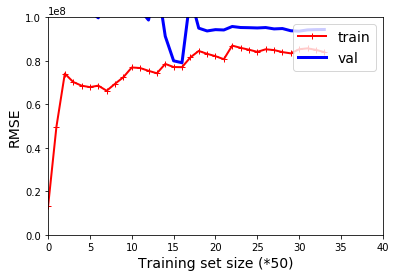

In [209]:
plot_learning_curves(lin_reg, X_train_prep.values, y_train.values)
plt.axis([0, 40, 0, 100000000])                         # not shown in the book
plt.show()                                      # not shown

Clear Linear regression seems to underfit the data

# Random Forest

In [210]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(X_train_prep, y_train.values)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [211]:
reve_pred=forest_reg.predict(X_test_prep)
rfr_mse = mean_squared_error(reve_pred, y_test)
rfr_rmse=np.sqrt(rfr_mse)
rfr_rmse

77122222.68444249

In [212]:
rfr_rmse/y_test.mean()

revenue    1.129688
dtype: float64

In [213]:
forest_reg.score(X_test_prep, y_test.values)

0.6246038171693433

In [214]:
forest_reg.score(X_train_prep, y_train.values)

0.9348305308110735

In [215]:
from sklearn.model_selection import GridSearchCV

In [320]:
param_grid = [
    {'n_estimators':[5,10,30,90,270], "max_features":[2,4,6,8],"min_samples_leaf":[3,9,27]},
    
    {"bootstrap":[True], "n_estimators":[3,10,30,90,270],"min_samples_leaf":[3,9,27],"max_features":[2,3,4]},
    
    {"bootstrap":[False], "n_estimators":[3,10,30,90,270],"min_samples_leaf":[3,9,27], "max_features":[2,3,4]},
    
]

In [321]:
forest_reg=RandomForestRegressor (random_state=10)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',return_train_score=True)

grid_search.fit(X_train_prep, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [5, 10, 30, 90, 270], 'max_features': [2, 4, 6, 8], 'min_samples_leaf': [3, 9, 27]}, {'bootstrap': [True], 'n_estimators': [3, 10, 30, 90, 270], 'min_samples_leaf': [3, 9, 27], 'max_features': [2, 3, 4]}, {'bootstrap': [False], 'n_estimators': [3, 10, 30, 90, 270], 'min_samples_leaf': [3, 9, 27], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [322]:
grid_search.best_params_

{'bootstrap': False,
 'max_features': 3,
 'min_samples_leaf': 3,
 'n_estimators': 30}

In [323]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(round(np.sqrt(-mean_score)/1000000), params)

91.0 {'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 5}
87.0 {'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 10}
85.0 {'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 30}
85.0 {'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 90}
85.0 {'max_features': 2, 'min_samples_leaf': 3, 'n_estimators': 270}
91.0 {'max_features': 2, 'min_samples_leaf': 9, 'n_estimators': 5}
89.0 {'max_features': 2, 'min_samples_leaf': 9, 'n_estimators': 10}
89.0 {'max_features': 2, 'min_samples_leaf': 9, 'n_estimators': 30}
90.0 {'max_features': 2, 'min_samples_leaf': 9, 'n_estimators': 90}
90.0 {'max_features': 2, 'min_samples_leaf': 9, 'n_estimators': 270}
105.0 {'max_features': 2, 'min_samples_leaf': 27, 'n_estimators': 5}
100.0 {'max_features': 2, 'min_samples_leaf': 27, 'n_estimators': 10}
97.0 {'max_features': 2, 'min_samples_leaf': 27, 'n_estimators': 30}
99.0 {'max_features': 2, 'min_samples_leaf': 27, 'n_estimators': 90}
100.0 {'max_features': 2, 'min_samples_leaf

In [324]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances;

In [325]:
attributes = X_train_prep.columns

In [326]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.12204159430333107, 'budget'),
 (0.11152707736477434, 'budget popularity'),
 (0.10150841257756477, 'budget runtime'),
 (0.0828996535007692, 'budget^2 runtime'),
 (0.07718441931123565, 'budget runtime popularity'),
 (0.05492493794385253, 'budget runtime^2'),
 (0.05044616496322421, 'budget^2'),
 (0.050080928134134256, 'budget^3'),
 (0.046640098653152086, 'budget^2 popularity'),
 (0.0402391109038733, 'runtime^2 popularity'),
 (0.03877671994378341, 'popularity^3'),
 (0.036924408849505166, 'budget popularity^2'),
 (0.033470202251290354, 'runtime popularity^2'),
 (0.0199390566763402, 'popularity'),
 (0.01619771593440911, 'popularity^2'),
 (0.015801895374616452, 'runtime popularity'),
 (0.012294194768288582, 'runtime'),
 (0.011547925328701775, 'Adventure'),
 (0.008665934898123782, 'runtime^3'),
 (0.007631096024209808, 'runtime^2'),
 (0.0055992941207466665, 'Animation'),
 (0.00422092730068476, 'prod_country_United States of America'),
 (0.003805997046474988, 'Family'),
 (0.00295263501952119

In [327]:
final_model = grid_search.best_estimator_

In [328]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=None, oob_score=False, random_state=10,
           verbose=0, warm_start=False)

In [329]:
reve_pred_fin=final_model.predict(X_test_prep)
fin_mse = mean_squared_error(reve_pred_fin, y_test)
fin_rmse=np.sqrt(fin_mse)
fin_rmse

71245246.63708396

In [330]:
fin_rmse/y_test.mean()

revenue    1.043602
dtype: float64

In [331]:
reve_pred_fin=final_model.predict(X_train_prep)
fin_mse = mean_squared_error(np.log1p(reve_pred_fin), np.log1p(y_train))
fin_rmse=np.sqrt(fin_mse)
fin_rmse

2.58599931742936

In [332]:
fin_rmse/y_test.mean()

revenue    3.787976e-08
dtype: float64

In [333]:
final_pred=pd.Series(final_model.predict(X_test_prep))

In [334]:
final_model.score(X_test_prep, y_test)

0.6796368423614129

In [335]:
mean_squared_error(np.log1p(reve_pred), np.log1p(y_test.values))

6.957288487033087

In [336]:
final_model.score(X_train_prep, y_train)

0.8598803479672069

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning:

A column

[0, 40, 0, 100000000]

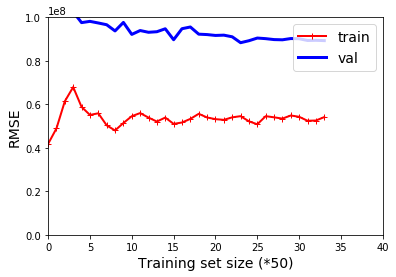

In [337]:
plot_learning_curves(final_model, X_train_prep.values, y_train.values)
plt.axis([0, 40, 0, 100000000])                         # not shown in the book
plt.show()                                    # not shown

While RandomForestsRegressor significantly overfits

# Lgb with KFoldValidation

In [233]:
import lightgbm as lgb
random_seed=42

In [234]:
lgbmodel = lgb.LGBMRegressor(n_estimators=10000, 
                             objective='regression', 
                             metric='rmse',
                             max_depth = 5,
                             num_leaves=5, 
                             min_child_samples=100,
                             learning_rate=0.001,
                             boosting = 'gbdt',
                             min_data_in_leaf= 10,
                             feature_fraction = 0.2,
                             bagging_freq = 1,
                             bagging_fraction = 0.9,
                             importance_type='gain',
                             lambda_l1 = 0.2,
                             bagging_seed=random_seed, 
                             subsample=.8, 
                             colsample_bytree=.9,
                             use_best_model=True)

In [235]:
lgbmodel.fit(X_train_prep, y_train)

LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=42,
       boosting='gbdt', boosting_type='gbdt', class_weight=None,
       colsample_bytree=0.9, feature_fraction=0.2, importance_type='gain',
       lambda_l1=0.2, learning_rate=0.001, max_depth=5, metric='rmse',
       min_child_samples=100, min_child_weight=0.001, min_data_in_leaf=10,
       min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=5,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=0.8,
       subsample_for_bin=200000, subsample_freq=0, use_best_model=True)

In [236]:
lgbmodel.score(X_test_prep, y_test)

0.6694378259946665

In [237]:
reve_pred=lgbmodel.predict(X_test_prep)
rfr_mse = mean_squared_error(reve_pred, y_test)
rfr_rmse=np.sqrt(rfr_mse)
rfr_rmse

72370436.0690906

In [238]:
rfr_rmse/y_test.mean()

revenue    1.060083
dtype: float64

In [239]:
type(lgbmodel)

lightgbm.sklearn.LGBMRegressor

In [240]:
type(final_model)


sklearn.ensemble.forest.RandomForestRegressor

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

[0, 40, 0, 100000000]

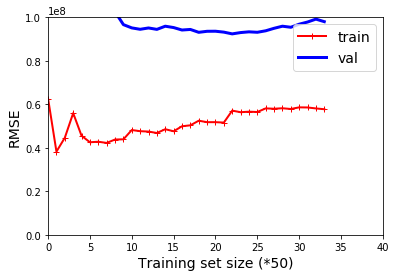

In [241]:
plot_learning_curves(lgbmodel, X_train_prep.values, y_train.values)
plt.axis([0, 40, 0, 100000000])                         # not shown in the book
plt.show()    

# Voting regressor

In [249]:
from sklearn.ensemble import BaggingRegressor

In [257]:
lin_reg=lin_reg
rf_reg=final_model
lgb_reg=lgbmodel

In [261]:
reve_pred_fin=lin_reg.predict(X_test_prep)*0.33+rf_reg.predict(X_test_prep)*0.34+lgb_reg.predict(X_test_prep)
ens_mse = mean_squared_error(reve_pred, y_test)
ens_rmse=np.sqrt(rfr_mse)
ens_rmse

72370436.0690906

In [263]:
ens_rmse/y_test.mean()

revenue    1.060083
dtype: float64

In [ ]:
reve_pred=lgbmodel.predict(X_test_prep)
rfr_mse = mean_squared_error(reve_pred, y_test)
rfr_rmse=np.sqrt(rfr_mse)
rfr_rmse

In [517]:
df_final_pred=pd.concat([final_pred, y_test], axis=1, sort=False)
df_final_pred.sort_values(by="prediction", inplace=True);
df_final_pred.reset_index(inplace=True);

In [518]:
df_final_pred.head()

,index,prediction,revenue
0,745,633582.800000,115605
1,493,711063.466667,105656
2,405,795815.716667,22321
3,308,888171.083333,11000
4,571,919354.866667,2586511


In [519]:
trace0=go.Scatter(
        y=df_final_pred.prediction,
        x=df_final_pred.index,
        name="prediction",
        mode='lines',
        marker=dict(
        color="blue",
        size=10,
        opacity=0.2
        )
    )



trace1=go.Scatter(
        y=df_final_pred.revenue,
        x=df_final_pred.index,
        name="revenue",
        mode='markers',
        marker=dict(
        color="red",
        size=10,
        opacity=0.2,
    
        )
    )



data=[trace0, trace1]
figure=go.Figure(
    data=data,
    layout=go.Layout(
            title="Basic features revenue prediction",
        xaxis=dict(title="Index"),
        yaxis=dict(title="Revenue"),
    
    ))
iplot(figure)

# Polynomial features

In [102]:
from sklearn.preprocessing import PolynomialFeatures
Poly_Feat=PolynomialFeatures(degree=3, include_bias=False)

class PolyAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        """

        init
        """
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_num=X[["budget","runtime","popularity"]]
        X_poly=Poly_Feat.fit_transform(X_num)
        poly_columns=[]
        for col in Poly_Feat.get_feature_names():
            col=str(col).replace("x0","budget")
            col=str(col).replace("x1","runtime")
            col=str(col).replace("x2","popularity")
            poly_columns.append(col)

        
        df_poly=pd.DataFrame(X_poly, columns=poly_columns)
        df_poly.drop(["budget","runtime","popularity"], axis=1, inplace=True)
        processed_X=pd.concat([X, df_poly], axis=1, sort=False)
    
        return processed_X
  

In [103]:
X_num=X_train_t[["budget","runtime","popularity"]]

In [104]:
 X_poly=Poly_Feat.fit_transform(X_num)
   

In [105]:
pol_col=Poly_Feat.get_feature_names()

In [106]:
d_col=dict([("x0","budget"),("x1", "runtime"), ("x2","popularity")])

In [107]:
poly_columns=[]
for col in Poly_Feat.get_feature_names():
    col=str(col).replace("x0","budget")
    col=str(col).replace("x1","runtime")
    col=str(col).replace("x2","popularity")
    poly_columns.append(col)


In [108]:
poly_att=PolyAttributesAdder()
X_train_poly=poly_att.fit_transform(X_train_t3)

In [109]:
X_train_poly.head()

,budget,popularity,runtime,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,...,budget^3,budget^2 runtime,budget^2 popularity,budget runtime^2,budget runtime popularity,budget popularity^2,runtime^3,runtime^2 popularity,runtime popularity^2,popularity^3
0,8575000,16.727405,145.0,0,0,0,0,0,0,1,...,6.305251e+20,1.066194e+16,1.229977e+15,1.802894e+11,2.079844e+10,2.399337e+09,3048625.0,351693.690125,40571.881315,4680.429589
1,4100000,3.826281,135.0,0,0,0,0,0,0,1,...,6.892100e+19,2.269350e+15,6.431978e+13,7.472250e+10,2.117847e+09,6.002575e+07,2460375.0,69733.971225,1976.457549,56.018385
2,80000000,14.398530,118.0,1,0,0,0,0,0,0,...,5.120000e+23,7.552000e+17,9.215059e+16,1.113920e+12,1.359221e+11,1.658541e+10,1643032.0,200485.131720,24463.484607,2985.069636
3,38000000,8.105708,118.0,1,1,0,0,0,0,0,...,5.487200e+22,1.703920e+17,1.170464e+16,5.291120e+11,3.634599e+10,2.496695e+09,1643032.0,112863.878192,7752.895257,532.565298
4,30000000,7.857666,115.0,0,0,1,0,0,0,0,...,2.700000e+22,1.035000e+17,7.071899e+15,3.967500e+11,2.710895e+10,1.852287e+09,1520875.0,103917.632850,7100.435221,485.155204


In [110]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_atrribs=[["budget", "runtime","popularity"]]

polynomial_pipeline = Pipeline([
    ("imputer", DataFrameImputer()),
    ("date_adder", DateAttributesAdder()),
    ("cat_adder", CatAttributesAdder()),
    ("polynomial_adder", PolyAttributesAdder(),)
    ])

In [111]:
X_train_poly.columns

Index([                                'budget',
                                   'popularity',
                                      'runtime',
                                       'Action',
                                    'Adventure',
                                    'Animation',
                                       'Comedy',
                                        'Crime',
                                  'Documentary',
                                        'Drama',
                                       'Family',
                                      'Fantasy',
                                      'Foreign',
                                      'History',
                                       'Horror',
                                        'Music',
                                      'Mystery',
                                      'Romance',
                              'Science Fiction',
                                     'Thriller',
                    

In [130]:
X_test_poly=polynomial_pipeline.fit_transform(X_test)

In [131]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [134]:
reve_pred=lin_reg.predict(X_test_poly)
lin_mse = mean_squared_error(np.log1p(reve_pred), np.log1p(y_test.values))
lin_rmse=np.sqrt(lin_mse)
lin_rmse

2.834987002825821

In [115]:
lin_reg.score(X_test_poly, y_test.values)

0.5755284132284635

[0, 2000, 0, 100312417]

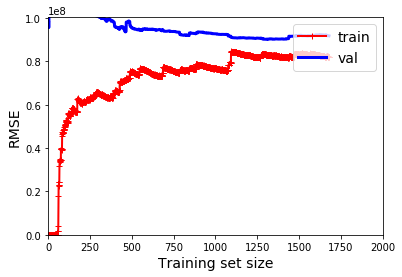

In [116]:
plot_learning_curves(lin_reg, X_train_prep.values, y_train.values)
plt.axis([0, 2000, 0, 100312417])                         # not shown in the book
plt.show()   

In [531]:
forest_reg_poly = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg_poly.fit(X_train_poly, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [532]:
reve_pred_poly=forest_reg_poly.predict(X_test_poly)
rfr_poly_mse = mean_squared_error(reve_pred_poly, y_test)
rfr_poly_rmse=np.sqrt(rfr_mse)
rfr_poly_rmse

75402263.20115954

In [533]:
rfr_poly_rmse/y_test.mean()

revenue    1.104494
dtype: float64

In [534]:
forest_reg_poly.score(X_test_poly, y_test)

0.6246038171693433

In [535]:
forest_reg=RandomForestRegressor (random_state=10)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',return_train_score=True)

grid_search.fit(X_train_poly, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

C:\ProgramData\Anaconda3

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [10, 30, 60], 'max_features': [4, 6, 8, 12]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [536]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

In [537]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances;

In [538]:
attributes = X_train_poly.columns

In [539]:
sorted(zip(feature_importances, attributes), reverse=True)

[(0.13406593012534593, 'budget popularity'),
 (0.09292264694482608, 'budget'),
 (0.08852175835560729, 'budget popularity^2'),
 (0.08004574726378114, 'budget runtime'),
 (0.07722800556726281, 'budget^2'),
 (0.058682455431872074, 'runtime^2 popularity'),
 (0.0493085155427748, 'budget^2 popularity'),
 (0.04462926771925785, 'budget^2 runtime'),
 (0.03137829907948025, 'budget runtime popularity'),
 (0.029351946696103505, 'popularity^2'),
 (0.026481961335355214, 'runtime popularity^2'),
 (0.024599431636504278, 'popularity'),
 (0.023635087909860814, 'budget runtime^2'),
 (0.020626892185156325, 'runtime popularity'),
 (0.02052972976737074, 'popularity^3'),
 (0.01926414786674997, 'runtime^3'),
 (0.019059894800845304, 'runtime'),
 (0.013949653610922883, 'runtime^2'),
 (0.013342995286182038, 'budget^3'),
 (0.008875122728487138, 'prod_country_United States of America'),
 (0.007717448309692274, 'Action'),
 (0.007416410178716568, 'Family'),
 (0.007205578780858477, 'Jun'),
 (0.005870711335733707, 'Dr

In [540]:
final_model = grid_search.best_estimator_

In [541]:
reve_pred_poly=final_model.predict(X_test_poly)
rfr_poly_mse = mean_squared_error(reve_pred_poly, y_test)
rfr_poly_rmse=np.sqrt(rfr_mse)
rfr_poly_rmse



75402263.20115954

In [542]:
rfr_poly_rmse/y_test.mean()

revenue    1.104494
dtype: float64

In [543]:
forest_reg_poly.score(X_test_poly, y_test)

0.6246038171693433

In [544]:
final_pred=pd.Series(final_model.predict(X_test_poly))

In [545]:
final_pred=pd.DataFrame(final_pred, columns=["prediction"])

In [546]:
df_final_pred=pd.concat([final_pred, y_test], axis=1, sort=False)
df_final_pred=df_final_pred.sort_values(by="prediction")

In [547]:
df_final_pred.reset_index(inplace=True)

In [548]:
trace0=go.Scatter(
        y=df_final_pred.prediction,
        x=df_final_pred.index,
        name="prediction",
        mode='lines',
        marker=dict(
        color="blue",
        size=10,
        opacity=0.2
        )
    )



trace1=go.Scatter(
        y=df_final_pred.revenue,
        x=df_final_pred.index,
        name="revenue",
        mode='markers',
        marker=dict(
        color="red",
        size=10,
        opacity=0.2,
    
        )
    )



data=[trace0, trace1]
figure=go.Figure(
    data=data,
    layout=go.Layout(
        title="Polynomial features revenue prediction",
        xaxis=dict(title="Index"),
        yaxis=dict(title="Revenue"),

    
    ))
iplot(figure)

In [95]:
from sklearn import ensemble


In [96]:
ens_reg=ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth=5, min_samples_split=2,
                                         learning_rate=0.1, loss="ls")

In [97]:
ens_reg.fit(X_train_prep, y_train.values)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=400, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [98]:
ens_reg.score(X_test_prep, y_test.values)

0.6422409721513591

In [99]:
ens_reg.score(X_train_prep, y_train.values)

0.9934651265789503

In [100]:
plot_learning_curves(ens_reg, X_train_prep.values, y_train.values)
plt.axis([0, 2000, 0, 100312417])                         # not shown in the book
plt.show()   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validat

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



KeyboardInterrupt: 